In [1]:
# ===== Cell: PHASE A — Data Understanding & Audit (1 cell = toàn Phase A) =====
# Mục tiêu: kiểm tra file, audit cột, lưu audit_columns.csv
import pandas as pd
from pathlib import Path
import json

# ---------- CẤU HÌNH ĐƯỜNG DẪN (KHÔNG THAY ĐỔI) ----------
DATA_PATH = Path(r"D:\UIT\Semester 5\Vocational Skills\love_survey_responses.xlsx")
PROJECT_DATA_DIR = Path("data")  # nơi lưu audit csv của project (không phải file gốc)

# ---------- HÀM HỖ TRỢ ----------
def top_values_str(s, n=3):
    try:
        vc = s.value_counts(dropna=False)
        items = [f"{idx} ({cnt})" for idx, cnt in zip(vc.index.astype(str).tolist()[:n], vc.values[:n])]
        return " | ".join(items)
    except Exception:
        return ""

def first_nonnull_samples(s, n=3):
    try:
        samples = s.dropna().astype(str).unique().tolist()[:n]
        return " | ".join(samples)
    except Exception:
        return ""

# ---------- CHẠY AUDIT ----------
print("PHASE A — Data Understanding & Audit")
print("Reading file path:", DATA_PATH)
print("Exists:", DATA_PATH.exists())
print()

if not DATA_PATH.exists():
    raise FileNotFoundError(f"File not found. Vui lòng kiểm tra lại đường dẫn chính xác: {DATA_PATH}")

# đọc file (openpyxl)
df = pd.read_excel(DATA_PATH, engine="openpyxl")

n_rows, n_cols = df.shape
print(f"Rows: {n_rows}, Columns: {n_cols}")
print()

print("=== 5 rows preview ===")
display(df.head())

# danh sách cột
print("\n=== Columns (index : name) ===")
for i, c in enumerate(df.columns, 1):
    print(f"{i:03d}. {c}")

# cột 100% empty
empty_cols = [c for c in df.columns if df[c].isna().all()]
print("\nColumns 100% empty (cần drop):", empty_cols)

# cột chỉ có 1 unique value
single_value_cols = [c for c in df.columns if df[c].nunique(dropna=False) <= 1]
print("Columns with <=1 unique value:", single_value_cols)

# exact duplicate columns (by content)
# transpose and find duplicated rows -> duplicated columns
dup_mask = df.T.duplicated(keep='first')
dup_columns = df.columns[dup_mask].tolist()
dup_groups = {}
if dup_columns:
    # group duplicates by their first occurrence
    for i, col in enumerate(df.columns):
        if dup_mask[i]:
            # find the first column equal to this one
            for j in range(i):
                if df.iloc[:, j].equals(df.iloc[:, i]):
                    dup_groups.setdefault(df.columns[j], []).append(df.columns[i])
                    break

print("Exact duplicate columns (content-wise):", dup_groups if dup_groups else [])

# detect likely timestamp/email columns by name
likely_timestamp = [c for c in df.columns if "time" in c.lower() or "timestamp" in c.lower() or "date" in c.lower()]
likely_email = [c for c in df.columns if "email" in c.lower()]
print("Columns likely Timestamp/Date-like:", likely_timestamp)
print("Columns likely Email-like:", likely_email)

# dtype summary, missing rate, unique counts, top values
audit_rows = []
for c in df.columns:
    s = df[c]
    n_missing = int(s.isna().sum())
    missing_rate = float(n_missing) / n_rows
    n_unique = int(s.nunique(dropna=False))
    dtype = str(s.dtype)
    top_values = top_values_str(s, n=3)
    samples = first_nonnull_samples(s, n=3)
    # mark free-text-like: object dtype and high cardinality (>50% rows unique)
    free_text_like = False
    try:
        if dtype in ("object", "string") and n_unique > 0.5 * n_rows:
            free_text_like = True
    except Exception:
        free_text_like = False
    audit_rows.append({
        "column": c,
        "dtype": dtype,
        "n_missing": n_missing,
        "missing_rate": round(missing_rate, 4),
        "n_unique": n_unique,
        "top_values": top_values,
        "sample_values": samples,
        "is_all_empty": c in empty_cols,
        "is_single_value": c in single_value_cols,
        "is_exact_dup_of": next((k for k, v in dup_groups.items() if c in v), ""),
        "likely_timestamp": c in likely_timestamp,
        "likely_email": c in likely_email,
        "free_text_like": free_text_like
    })

audit_df = pd.DataFrame(audit_rows)

# thêm một vài tóm tắt
numeric_cols = audit_df[audit_df["dtype"].str.contains("int|float|number", case=False, na=False)]["column"].tolist()
categorical_hint = audit_df[~audit_df["column"].isin(numeric_cols)]["column"].tolist()

print("\nNumeric-like columns (inferred):", numeric_cols)
print("Categorical/Text-like columns (inferred):", categorical_hint[:10], "..." if len(categorical_hint) > 10 else "")

# high-cardinality text columns
high_card_text = audit_df[(audit_df["free_text_like"])][["column", "n_unique"]]
if not high_card_text.empty:
    print("\nColumns likely free-text (high cardinality):")
    display(high_card_text)

# Save audit csv
PROJECT_DATA_DIR.mkdir(parents=True, exist_ok=True)
audit_path = PROJECT_DATA_DIR / "audit_columns.csv"
audit_df.to_csv(audit_path, index=False, encoding="utf-8-sig")
print(f"\nAudit saved to: {audit_path}  (open this file to review suggested actions)")

# Save a short JSON summary for quick programmatic use
summary = {
    "rows": n_rows,
    "cols": n_cols,
    "n_empty_columns": len(empty_cols),
    "n_single_value_columns": len(single_value_cols),
    "n_exact_duplicate_groups": len(dup_groups),
    "likely_timestamp_columns": likely_timestamp,
    "likely_email_columns": likely_email
}
with open(PROJECT_DATA_DIR / "audit_summary.json", "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

print("\nPHASE A complete: audit saved. Please paste the full output (and/or content of data/audit_columns.csv) here so I can review and then send PHASE B cell.")
# ============================================================================== 


PHASE A — Data Understanding & Audit
Reading file path: D:\UIT\Semester 5\Vocational Skills\love_survey_responses.xlsx
Exists: True

Rows: 208, Columns: 52

=== 5 rows preview ===


,Timestamp,Giới tính của bạn là?,Độ tuổi của bạn là?,Xu hướng tính dục của bạn là?,Tôn giáo của bạn là?,Tình trạng việc làm hiện tại của bạn?,Bạn đánh giá sức khoẻ thể chất của mình như thế nào?,Bạn cảm thấy ngoại hình của mình như thế nào?,Trình độ học vấn hiện tại của bạn?,Bạn hiện có đang trong một mối quan hệ tình cảm không?,...,Những lỗi lầm nào có thể tha thứ trong tình yêu?,Bạn có tin vào tình yêu sét đánh không?,Bạn nghĩ tình yêu có cần gắn với tình dục không?,Bạn nghĩ ở tuổi nào nên kết hôn là hợp lý?,Bạn cảm thấy gia đình có ảnh hưởng đến mối quan hệ của bạn như thế nào?,Score,Email Address,Column 48,Column 48.1,Bạn cảm thấy gia đình có ảnh hưởng đến mối quan hệ của bạn không?
0,2025-10-11 17:33:36.626,Nam,18 - 22,Dị tính,Không có,Chỉ học,3,3,Đại học,Không,...,"Trễ giờ, Ăn mặc bất lịch sự",Không,Tuỳ mối quan hệ,Dưới 25,NaN,0,NaN,NaN,NaN,NaN
1,2025-10-11 17:57:18.692,Nam,18 - 22,Đồng tính,Không có,Chỉ học,5,2,Đại học,Không,...,"Trễ giờ, Ăn mặc bất lịch sự, Ăn nói thiếu chuẩ...",Không,Không,28 – 30,NaN,0,NaN,NaN,NaN,NaN
2,2025-10-11 18:01:03.520,Nam,18 - 22,Dị tính,Không có,Chỉ học,3,2,Đại học,Không,...,"Trễ giờ, Ăn mặc bất lịch sự",Có,Tuỳ mối quan hệ,Dưới 25,NaN,0,NaN,NaN,NaN,NaN
3,2025-10-11 18:04:04.443,Nam,18 - 22,Dị tính,Không có,Chỉ học,5,2,Đại học,Không,...,"Trễ giờ, Ăn mặc bất lịch sự, Ăn nói thiếu chuẩ...",Không,Tuỳ mối quan hệ,28 – 30,NaN,0,NaN,NaN,NaN,NaN
4,2025-10-11 18:05:53.782,Nam,18 - 22,Khác,Không có,Chỉ học,5,3,Đại học,Không,...,Không tôn trọng gia đình người yêu,Không,Tuỳ mối quan hệ,28 – 30,NaN,0,NaN,NaN,NaN,NaN



=== Columns (index : name) ===
001. Timestamp
002. Giới tính của bạn là?
003. Độ tuổi của bạn là?
004. Xu hướng tính dục của bạn là?
005. Tôn giáo của bạn là?
006. Tình trạng việc làm hiện tại của bạn?
007. Bạn đánh giá sức khoẻ thể chất của mình như thế nào?
008. Bạn cảm thấy ngoại hình của mình như thế nào?
009. Trình độ học vấn hiện tại của bạn?
010. Bạn hiện có đang trong một mối quan hệ tình cảm không?
011. Nếu chưa thì có những lý do nào khiến bạn chưa có người yêu?
012. Bạn có mong muốn tìm được người yêu trong tương lai gần không?
013. Bạn mong muốn mối quan hệ trong tương lai sẽ kéo dài bao lâu?
014. Tiêu chí quan trọng nhất với bạn khi chọn người yêu?
015. Bạn có cảm thấy áp lực từ gia đình hoặc xã hội về việc phải có người yêu không?
016. Bạn đã từng/ thử tiếp cận tình yêu qua cách nào?
017. BẠN CÓ TIN VÀO TÌNH YÊU SÉT ĐÁNH KHÔNG?
018. Bạn đã từng trải qua một mối tình chính thức chưa?
019. Nếu có thì bạn đã chia tay vì những lý do gì?
020. BẠN NGHĨ Ở ĐỘ TUỔI NÀO THÌ NÊN KẾ

C:\Users\ASUS\AppData\Local\Temp\ipykernel_33956\2633851631.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if dup_mask[i]:


,column,n_unique
48,Email Address,165



Audit saved to: data\audit_columns.csv  (open this file to review suggested actions)

PHASE A complete: audit saved. Please paste the full output (and/or content of data/audit_columns.csv) here so I can review and then send PHASE B cell.


In [2]:
# ===== Cell: PHASE B — Data Cleaning =====
import pandas as pd
from pathlib import Path
import re

# -----------------------------
# 1) Load file nguồn
# -----------------------------
DATA_PATH = Path(r"D:\UIT\Semester 5\Vocational Skills\love_survey_responses.xlsx")
OUTPUT_PATH = Path("data/clean_data_v1.csv")

df = pd.read_excel(DATA_PATH, engine="openpyxl")
print("Loaded:", df.shape, "rows x columns")

# -----------------------------
# 2) Drop các cột rác theo Phase A
# -----------------------------
cols_empty = [
    'BẠN CÓ TIN VÀO TÌNH YÊU SÉT ĐÁNH KHÔNG?',
    'BẠN NGHĨ Ở ĐỘ TUỔI NÀO THÌ NÊN KẾT HÔN?',
    'Column 20',
    'BẠN CÓ COI TÌNH YÊU HIỆN TẠI LÀ BƯỚC ĐẾN HÔN NHÂN KHÔNG  ',
    'Column 48',
    'Column 48.1',
    'Bạn cảm thấy gia đình có ảnh hưởng đến mối quan hệ của bạn không?',
]

cols_dup = [
    'BẠN NGHĨ Ở ĐỘ TUỔI NÀO THÌ NÊN KẾT HÔN?',
    'Column 20',
    'BẠN CÓ COI TÌNH YÊU HIỆN TẠI LÀ BƯỚC ĐẾN HÔN NHÂN KHÔNG  ',
    'Column 48',
    'Column 48.1',
    'Bạn cảm thấy gia đình có ảnh hưởng đến mối quan hệ của bạn không?',
]

cols_email = ['Email Address']
cols_timestamp = ['Timestamp']

cols_to_drop = list(set(cols_empty + cols_dup + cols_email + cols_timestamp))
cols_to_drop = [c for c in cols_to_drop if c in df.columns]

df = df.drop(columns=cols_to_drop)
print("After dropping unusable columns:", df.shape)

# -----------------------------
# 3) Chuẩn hóa Có/Không → 1/0
# -----------------------------
def normalize_yes_no(x):
    if pd.isna(x):
        return x
    x = str(x).strip().lower()
    if x in ["có", "yes", "y", "1", "co", "true"]:
        return 1
    if x in ["không", "ko", "khong", "no", "0", "false"]:
        return 0
    return x  # giá trị khác giữ nguyên

df = df.applymap(normalize_yes_no)

# -----------------------------
# 4) Chuẩn hóa các câu Likert (5 mức)
# -----------------------------
likert_map = {
    "rất không đồng ý": 1,
    "không đồng ý": 2,
    "phân vân": 3,
    "trung lập": 3,
    "đồng ý": 4,
    "rất đồng ý": 5,
}

def normalize_likert(x):
    if pd.isna(x):
        return x
    x_low = str(x).strip().lower()
    return likert_map.get(x_low, x)  # không map được thì giữ nguyên

df = df.applymap(normalize_likert)

# -----------------------------
# 5) Rename tất cả cột về dạng slug an toàn
#    + Tạo mapping đặc biệt cho Label A/B
# -----------------------------
def slugify(name):
    name = name.strip()
    name = re.sub(r"[^\w\s]", "", name)
    name = name.replace(" ", "_")
    name = re.sub("_+", "_", name)
    return name.lower()

rename_map = {c: slugify(c) for c in df.columns}

# Override cho 2 labels
for original, new in [
    ("Bạn có tin vào tình yêu sét đánh không?", "label_a_love_at_first_sight"),
    ("Bạn đã từng trải qua một mối tình chính thức chưa?", "label_b_has_had_official_relationship"),
]:
    if original in rename_map:
        rename_map[original] = new

df = df.rename(columns=rename_map)

print("Columns after renaming:")
print(df.columns.tolist())

# -----------------------------
# 6) Lưu output
# -----------------------------
OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(OUTPUT_PATH, index=False, encoding="utf-8-sig")

print("\nPHASE B COMPLETE — cleaned file saved to:", OUTPUT_PATH)


Loaded: (208, 52) rows x columns
After dropping unusable columns: (208, 43)
Columns after renaming:
['giới_tính_của_bạn_là', 'độ_tuổi_của_bạn_là', 'xu_hướng_tính_dục_của_bạn_là', 'tôn_giáo_của_bạn_là', 'tình_trạng_việc_làm_hiện_tại_của_bạn', 'bạn_đánh_giá_sức_khoẻ_thể_chất_của_mình_như_thế_nào', 'bạn_cảm_thấy_ngoại_hình_của_mình_như_thế_nào', 'trình_độ_học_vấn_hiện_tại_của_bạn', 'bạn_hiện_có_đang_trong_một_mối_quan_hệ_tình_cảm_không', 'nếu_chưa_thì_có_những_lý_do_nào_khiến_bạn_chưa_có_người_yêu', 'bạn_có_mong_muốn_tìm_được_người_yêu_trong_tương_lai_gần_không', 'bạn_mong_muốn_mối_quan_hệ_trong_tương_lai_sẽ_kéo_dài_bao_lâu', 'tiêu_chí_quan_trọng_nhất_với_bạn_khi_chọn_người_yêu', 'bạn_có_cảm_thấy_áp_lực_từ_gia_đình_hoặc_xã_hội_về_việc_phải_có_người_yêu_không', 'bạn_đã_từng_thử_tiếp_cận_tình_yêu_qua_cách_nào', 'label_b_has_had_official_relationship', 'nếu_có_thì_bạn_đã_chia_tay_vì_những_lý_do_gì', 'mối_quan_hệ_của_bạn_đã_kéo_dài_bao_lâu', 'bạn_và_người_yêu_hiện_tại_quen_nhau_qua_phương_thứ

C:\Users\ASUS\AppData\Local\Temp\ipykernel_33956\3023055198.py:59: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(normalize_yes_no)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_33956\3023055198.py:79: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(normalize_likert)


In [5]:
# ===== PHASE B (FIXED) — Full Data Cleaning (1 cell) =====
# - Reads original Excel at D:\UIT\Semester 5\Vocational Skills\love_survey_responses.xlsx
# - Outputs:
#   data/col_rename_map.csv
#   data/clean_data_v1.csv
#   data/clean_for_labelA.csv
#   data/clean_for_labelB.csv
#   data/cleaning_changes.json
# Notes: DOES NOT impute label columns; impute only features.

import pandas as pd
import numpy as np
from pathlib import Path
import re, json

# ---------- Config ----------
DATA_PATH = Path(r"D:\UIT\Semester 5\Vocational Skills\love_survey_responses.xlsx")
OUT_DIR = Path("data")
OUT_DIR.mkdir(parents=True, exist_ok=True)

COL_RENAME_PATH = OUT_DIR / "col_rename_map.csv"
CLEAN_V1_PATH = OUT_DIR / "clean_data_v1.csv"
CLEAN_A_PATH = OUT_DIR / "clean_for_labelA.csv"
CLEAN_B_PATH = OUT_DIR / "clean_for_labelB.csv"
CHANGES_PATH = OUT_DIR / "cleaning_changes.json"

LABEL_A_ORIG = "Bạn có tin vào tình yêu sét đánh không?"
LABEL_B_ORIG = "Bạn đã từng trải qua một mối tình chính thức chưa?"
LABEL_A = "label_a_love_at_first_sight"
LABEL_B = "label_b_has_had_official_relationship"

# ---------- Helper ----------
def slugify(name: str) -> str:
    s = str(name).strip()
    s = re.sub(r"[^\w\s]", "", s)
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"_+", "_", s)
    return s.lower()

YESNO_MAP = {
    "có": 1, "co":1, "yes":1, "y":1, "true":1, "1":1,
    "không": 0, "khong":0, "ko":0, "no":0, "false":0, "0":0
}
LIKERT_MAP = {
    "rất không đồng ý": 1, "rat khong dong y":1,
    "không đồng ý": 2, "khong dong y":2,
    "phân vân": 3, "phan van":3, "trung lập":3,
    "đồng ý": 4, "dong y":4,
    "rất đồng ý": 5, "rat dong y":5
}

# ---------- Read original ----------
print("Reading:", DATA_PATH)
if not DATA_PATH.exists():
    raise FileNotFoundError(f"File not found: {DATA_PATH}")
df_orig = pd.read_excel(DATA_PATH, engine="openpyxl")
print("Original shape:", df_orig.shape)

# ---------- Detect cols to drop ----------
empty_cols = df_orig.columns[df_orig.isna().all()].tolist()
dup_mask = df_orig.T.duplicated(keep="first")
dup_cols = df_orig.columns[dup_mask].tolist()
likely_timestamp = [c for c in df_orig.columns if re.search(r"time|timestamp|date", str(c), flags=re.I)]
likely_email = [c for c in df_orig.columns if re.search(r"email", str(c), flags=re.I)]
explicit_junk = [c for c in ["Column 20","Column 48","Column 48.1","Score"] if c in df_orig.columns]

cols_to_drop = sorted(set(empty_cols + dup_cols + likely_timestamp + likely_email + explicit_junk))
cols_to_drop_existing = [c for c in cols_to_drop if c in df_orig.columns]

print(f"Detected to_drop: empty={len(empty_cols)}, dup={len(dup_cols)}, ts={len(likely_timestamp)}, email={len(likely_email)}, explicit_junk={len(explicit_junk)}")
print("Example to_drop (up to 20):", cols_to_drop_existing[:20])

# ---------- Create rename map and save ----------
rename_map = {c: slugify(c) for c in df_orig.columns}
if LABEL_A_ORIG in rename_map:
    rename_map[LABEL_A_ORIG] = LABEL_A
if LABEL_B_ORIG in rename_map:
    rename_map[LABEL_B_ORIG] = LABEL_B

pd.DataFrame({"original": list(rename_map.keys()), "suggested": list(rename_map.values())}) \
  .to_csv(COL_RENAME_PATH, index=False, encoding="utf-8-sig")
print("Saved col rename map to:", COL_RENAME_PATH)

# ---------- Build cleaned df (drop + rename) ----------
df = df_orig.copy()
if cols_to_drop_existing:
    df = df.drop(columns=cols_to_drop_existing)
print("After drop shape:", df.shape)
df = df.rename(columns={orig:rename_map.get(orig, orig) for orig in df.columns})
print("After rename sample cols:", list(df.columns)[:12])

# ---------- Normalize Yes/No and Likert (safe assign only to matching cells) ----------
for col in df.columns:
    # operate on string/object columns and also allow existing numbers to remain
    if df[col].dtype == object or str(df[col].dtype).startswith("string"):
        s = df[col].astype("string").str.strip().str.lower()

        # Yes/No mapping: only assign where exact match in YESNO_MAP
        mask_yes = s.isin(YESNO_MAP.keys())
        if mask_yes.any():
            mapped = s.map(YESNO_MAP)
            df.loc[mask_yes, col] = mapped[mask_yes].astype("Int64")

        # Likert mapping: only assign where exact match in LIKERT_MAP
        s2 = df[col].astype("string").str.strip().str.lower()
        mask_lik = s2.isin(LIKERT_MAP.keys())
        if mask_lik.any():
            mapped_l = s2.map(LIKERT_MAP)
            df.loc[mask_lik, col] = mapped_l[mask_lik].astype("Int64")

# ---------- Coerce columns that are overwhelmingly numeric to numeric dtype ----------
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col].dtype):
        continue
    coerced = pd.to_numeric(df[col], errors='coerce')
    if coerced.notna().sum() >= 0.9 * len(coerced):
        df[col] = coerced

# ---------- Identify columns for imputation (EXCLUDE LABELS) ----------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_impute_cols = [c for c in numeric_cols if c not in (LABEL_A, LABEL_B)]
obj_cols = [c for c in df.columns if c not in numeric_cols and c not in (LABEL_A, LABEL_B)]

# ---------- Impute features only ----------
numeric_imputed = {}
for c in numeric_impute_cols:
    n_miss = int(df[c].isna().sum())
    if n_miss > 0:
        med = df[c].median()
        df[c] = df[c].fillna(med)
        numeric_imputed[c] = int(n_miss)

categorical_imputed = {}
for c in obj_cols:
    n_miss = int(df[c].isna().sum())
    if n_miss > 0:
        df[c] = df[c].fillna("Unknown")
        categorical_imputed[c] = int(n_miss)

# ---------- Create per-label datasets: drop rows where that label is missing (NaN) ----------
initial_rows = len(df)
# Note: labels were never imputed -> NaN preserved; if label column absent, behave accordingly
df_for_a = df[df[LABEL_A].notna()].copy() if LABEL_A in df.columns else df.copy()
df_for_b = df[df[LABEL_B].notna()].copy() if LABEL_B in df.columns else df.copy()
dropped_for_a = initial_rows - len(df_for_a)
dropped_for_b = initial_rows - len(df_for_b)

# ---------- Save outputs ----------
df.to_csv(CLEAN_V1_PATH, index=False, encoding="utf-8-sig")
df_for_a.to_csv(CLEAN_A_PATH, index=False, encoding="utf-8-sig")
df_for_b.to_csv(CLEAN_B_PATH, index=False, encoding="utf-8-sig")

changes = {
    "initial_rows": int(len(df_orig)),
    "after_drop_rename_rows": int(len(df)),
    "after_drop_rename_cols": int(len(df.columns)),
    "cols_dropped": cols_to_drop_existing,
    "numeric_imputed_counts": numeric_imputed,
    "categorical_imputed_counts": categorical_imputed,
    "rows_dropped_for_labelA": int(dropped_for_a),
    "rows_dropped_for_labelB": int(dropped_for_b),
    "col_rename_map_path": str(COL_RENAME_PATH),
    "clean_v1_path": str(CLEAN_V1_PATH),
    "clean_for_labelA_path": str(CLEAN_A_PATH),
    "clean_for_labelB_path": str(CLEAN_B_PATH)
}
with open(CHANGES_PATH, "w", encoding="utf-8") as f:
    json.dump(changes, f, ensure_ascii=False, indent=2)

# ---------- Summary ----------
print("\nPHASE B (fixed) COMPLETE.")
print(f"Cleaned primary dataset saved: {CLEAN_V1_PATH}  (rows={len(df)}, cols={len(df.columns)})")
print(f"Per-label datasets saved: labelA -> {CLEAN_A_PATH} (rows={len(df_for_a)}), labelB -> {CLEAN_B_PATH} (rows={len(df_for_b)})")
print(f"Rename map saved: {COL_RENAME_PATH}")
print(f"Cleaning changes saved: {CHANGES_PATH}")
print("\nDropped columns count:", len(cols_to_drop_existing))
print("Numeric columns imputed (count by col):", numeric_imputed)
print("Categorical columns imputed (count by col):", categorical_imputed)
print("Rows dropped for labelA:", int(dropped_for_a), "Rows dropped for labelB:", int(dropped_for_b))
print("\nIf you want labels imputed instead of dropping rows, tell me and I will change strategy.")


Reading: D:\UIT\Semester 5\Vocational Skills\love_survey_responses.xlsx
Original shape: (208, 52)
Detected to_drop: empty=7, dup=6, ts=1, email=1, explicit_junk=4
Example to_drop (up to 20): ['BẠN CÓ COI TÌNH YÊU HIỆN TẠI LÀ BƯỚC ĐẾN HÔN NHÂN KHÔNG  ', 'BẠN CÓ TIN VÀO TÌNH YÊU SÉT ĐÁNH KHÔNG?', 'BẠN NGHĨ Ở ĐỘ TUỔI NÀO THÌ NÊN KẾT HÔN?', 'Bạn cảm thấy gia đình có ảnh hưởng đến mối quan hệ của bạn không?', 'Column 20', 'Column 48', 'Column 48.1', 'Email Address', 'Score', 'Timestamp']
Saved col rename map to: data\col_rename_map.csv
After drop shape: (208, 42)
After rename sample cols: ['giới_tính_của_bạn_là', 'độ_tuổi_của_bạn_là', 'xu_hướng_tính_dục_của_bạn_là', 'tôn_giáo_của_bạn_là', 'tình_trạng_việc_làm_hiện_tại_của_bạn', 'bạn_đánh_giá_sức_khoẻ_thể_chất_của_mình_như_thế_nào', 'bạn_cảm_thấy_ngoại_hình_của_mình_như_thế_nào', 'trình_độ_học_vấn_hiện_tại_của_bạn', 'bạn_hiện_có_đang_trong_một_mối_quan_hệ_tình_cảm_không', 'nếu_chưa_thì_có_những_lý_do_nào_khiến_bạn_chưa_có_người_yêu', 'bạn_có

d:\Program\ml\love-survey-ml\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading cleaned dataset: data\clean_data_v1.csv
Shape: (208, 42)
Columns: 42
EDA summary saved to: reports\eda_summary.csv


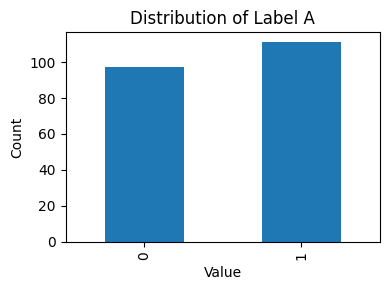

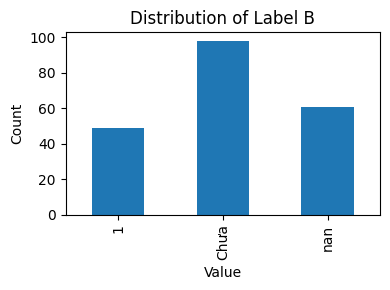

Generating ProfileReport (this may take ~10–20 seconds)...


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 152.92it/s]

ProfileReport saved to: reports\eda_report.html

PHASE C COMPLETE — EDA + Profile Report created.


In [1]:
# ===== PHASE C (FULL) — Exploratory Data Analysis (EDA + ProfileReport) =====
# 1 PHASE = 1 cell — theo yêu cầu của bạn

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from ydata_profiling import ProfileReport

# --------------------------------------------------------------
# CONFIG
# --------------------------------------------------------------
DATA_PATH = Path("data/clean_data_v1.csv")   # đã được tạo từ Phase B
REPORT_DIR = Path("reports")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

HTML_REPORT = REPORT_DIR / "eda_report.html"
EDA_SUMMARY_PATH = REPORT_DIR / "eda_summary.csv"

# --------------------------------------------------------------
# LOAD DATA
# --------------------------------------------------------------
print("Loading cleaned dataset:", DATA_PATH)
df = pd.read_csv(DATA_PATH, encoding="utf-8-sig")
print("Shape:", df.shape)
print("Columns:", len(df.columns))

# --------------------------------------------------------------
# BASIC SUMMARY (save to CSV)
# --------------------------------------------------------------
summary = pd.DataFrame({
    "column": df.columns,
    "dtype": df.dtypes.astype(str).values,
    "n_missing": df.isna().sum().values,
    "unique_values": df.nunique().values
})
summary.to_csv(EDA_SUMMARY_PATH, index=False, encoding="utf-8-sig")
print("EDA summary saved to:", EDA_SUMMARY_PATH)

# --------------------------------------------------------------
# DISTRIBUTION CHARTS (LABEL A / LABEL B)
# --------------------------------------------------------------
label_a = "label_a_love_at_first_sight"
label_b = "label_b_has_had_official_relationship"

if label_a in df.columns:
    plt.figure(figsize=(4,3))
    df[label_a].value_counts(dropna=False).sort_index().plot(kind="bar")
    plt.title("Distribution of Label A")
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

if label_b in df.columns:
    plt.figure(figsize=(4,3))
    df[label_b].value_counts(dropna=False).sort_index().plot(kind="bar")
    plt.title("Distribution of Label B")
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# --------------------------------------------------------------
# PROFILE REPORT (HTML) — REPORT GIỐNG MẪU CỦA BẠN
# --------------------------------------------------------------
print("Generating ProfileReport (this may take ~10–20 seconds)...")

profile = ProfileReport(
    df,
    title="Love Survey — EDA Profile Report",
    explorative=True,
    sensitive=False,
)

profile.to_file(HTML_REPORT)
print("ProfileReport saved to:", HTML_REPORT)

# --------------------------------------------------------------
# DONE
# --------------------------------------------------------------
print("\nPHASE C COMPLETE — EDA + Profile Report created.")


In [3]:
# ===== PHASE D — FEATURE PREPARATION (1 cell = toàn Phase D) =====
# Outputs (saved to data/):
# - data/X_features.csv                (feature matrix for full dataset)
# - data/feature_pipeline.pkl          (preprocessing pipeline)
# - data/feature_info.json             (metadata: selected features, mapping)
# Notes: Reads data/clean_data_v1.csv and data/clean_for_labelA.csv / clean_for_labelB.csv

import pandas as pd
import numpy as np
from pathlib import Path
import json
import re
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import joblib

# -------- CONFIG --------
DATA_DIR = Path("data")
CLEAN_PATH = DATA_DIR / "clean_data_v1.csv"
CLEAN_A = DATA_DIR / "clean_for_labelA.csv"
CLEAN_B = DATA_DIR / "clean_for_labelB.csv"
OUT_X = DATA_DIR / "X_features.csv"
PIPE_OUT = DATA_DIR / "feature_pipeline.pkl"
INFO_OUT = DATA_DIR / "feature_info.json"

# thresholds / params
oh_threshold = 10          # cardinality threshold for one-hot encoding
top_k = 20                 # number of top features to keep per-label for RF selection
random_state = 42

print("PHASE D — Feature Preparation starting...")
print("Loading cleaned data:", CLEAN_PATH)
df = pd.read_csv(CLEAN_PATH, encoding="utf-8-sig")
print("Loaded shape:", df.shape)

# LABEL NAMES (standardized earlier)
label_a = "label_a_love_at_first_sight"
label_b = "label_b_has_had_official_relationship"

# ---- helper: detect column types ----
def is_likert_like(col_name):
    # heuristic: contains keywords often in Likert questions
    kws = ["đồng ý", "đồng_y", "rất", "hài_lòng", "mức_độ", "độ", "độ_ghen", "mức_độ"]
    cn = str(col_name).lower()
    return any(k in cn for k in kws)

def find_cols_by_keywords(df_cols, keywords):
    cols = []
    for c in df_cols:
        low = str(c).lower()
        if any(k in low for k in keywords):
            cols.append(c)
    return cols

# ---- identify numeric vs categorical vs object columns ----
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
obj_cols = [c for c in df.columns if c not in numeric_cols]
# Exclude labels from feature lists
features_all = [c for c in df.columns if c not in (label_a, label_b)]

# Determine categorical candidates among obj_cols (string-like)
cat_candidates = [c for c in obj_cols if c in features_all]
# Determine likely likert (if any still object)
likert_cols = [c for c in features_all if is_likert_like(c)]
# But also check numeric columns that may be ordinal already
likert_cols = list(dict.fromkeys(likert_cols))  # unique

print("Detected numeric cols:", len(numeric_cols))
print("Detected categorical/object cols:", len(cat_candidates))
print("Detected likert-like cols (heuristic):", likert_cols)

# ---- ORDINAL MAPPING for common Likert strings (if present) ----
likert_map = {
    "rất không đồng ý": 1, "rat_khong_dong_y":1, "rat khong dong y":1,
    "không đồng ý": 2, "khong_dong_y":2, "khong dong y":2,
    "phân vân": 3, "phan van":3, "trung lập":3, "trung lap":3,
    "đồng ý": 4, "dong y":4,
    "rất đồng ý": 5, "rat dong y":5
}

def map_likert_series(s):
    # convert to string lowercase and map if possible; else leave
    s2 = s.astype("string").str.strip().str.lower().str.replace(r"\s+", " ", regex=True)
    mapped = s2.map(lambda x: likert_map.get(x, np.nan))
    # if many mapped values, return mapped else return original series
    if mapped.notna().sum() > 0:
        return mapped
    return s

# Apply ordinal mapping to object-like likert candidates
for c in likert_cols:
    if c in df.columns:
        mapped = map_likert_series(df[c])
        # if mapped produced numeric values for some cells, assign them (keep rest as-is)
        if mapped.notna().sum() > 0:
            df.loc[mapped.notna(), c] = mapped[mapped.notna()]
            # coerce to numeric if majority numeric
            coerced = pd.to_numeric(df[c], errors="coerce")
            if coerced.notna().sum() >= 0.5 * len(coerced):
                df[c] = coerced

# Refresh numeric / categorical sets after mapping
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_candidates = [c for c in df.columns if c not in numeric_cols and c not in (label_a, label_b)]

# Remove any unnatural large-text columns from features (free text)
# Heuristic: cardinality > 0.5 * n_rows and dtype object -> treat as free text and drop from modeling features
n_rows = len(df)
free_text_cols = [c for c in cat_candidates if df[c].nunique(dropna=False) > 0.5 * n_rows]
if free_text_cols:
    print("Detected high-cardinality free-text columns (will be excluded from features):", free_text_cols)
# final feature list excluding free-text
feature_candidates = [c for c in features_all if c not in free_text_cols and c not in (label_a, label_b)]

# ---- Feature engineering: composite scores (heuristic using VN keywords) ----
# Define keyword groups
romantic_kw = ["tình_yêu", "tinh_yeu", "tình yêu", "yeu", "romantic", "romance"]
social_pressure_kw = ["áp_lực", "ap_luc", "gia_đình", "gia_dinh", "áp lực", "gia đình"]
jealousy_kw = ["ghen", "ghen_tị", "ghen_ti"]
communication_kw = ["chia_sẻ", "chia_se", "chia sẻ", "giao tiếp", "giao_tiep", "communication", "truyền thông"]

def make_composite(df, kws):
    cols = find_cols_by_keywords(df.columns, kws)
    cols = [c for c in cols if c in df.columns and np.issubdtype(df[c].dtype, np.number)]
    if not cols:
        return None, []
    comp = df[cols].mean(axis=1)
    return comp, cols

rom_score, rom_cols = make_composite(df, romantic_kw)
soc_score, soc_cols = make_composite(df, social_pressure_kw)
jez_score, jez_cols = make_composite(df, jealousy_kw)
com_score, com_cols = make_composite(df, communication_kw)

# attach composite features (if any)
added = []
if rom_score is not None:
    df["romantic_score"] = rom_score
    added.append("romantic_score")
if soc_score is not None:
    df["social_pressure_index"] = soc_score
    added.append("social_pressure_index")
if jez_score is not None:
    df["jealousy_index"] = jez_score
    added.append("jealousy_index")
if com_score is not None:
    df["communication_score"] = com_score
    added.append("communication_score")

print("Composite scores added:", added)
print("Romantic cols used:", rom_cols)
print("Social pressure cols used:", soc_cols)
print("Jealousy cols used:", jez_cols)
print("Communication cols used:", com_cols)

# update feature candidates to include new composites
feature_candidates = [c for c in feature_candidates if c not in (label_a, label_b)]
feature_candidates += added

# ---- Encoding strategy: decide which categorical cols get one-hot vs freq-encoding ----
cat_cols = [c for c in feature_candidates if c in cat_candidates]
oh_cols = [c for c in cat_cols if df[c].nunique(dropna=False) <= oh_threshold]
freq_cols = [c for c in cat_cols if c not in oh_cols]

print("Categorical columns total:", len(cat_cols))
print("One-hot columns (<=%d unique): %d" % (oh_threshold, len(oh_cols)))
print("Frequency-encoded columns: %d" % len(freq_cols))

# ---- Build feature processing pipeline ----
# Frequency encoder implemented as a simple transformer
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        self.maps_ = {}
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        for c in self.cols:
            vc = X[c].fillna("__MISSING__").value_counts(normalize=True)
            self.maps_[c] = vc.to_dict()
        return self
    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for c in self.cols:
            X[c] = X[c].fillna("__MISSING__").map(self.maps_.get(c, {})).astype(float)
            X[c] = X[c].fillna(0.0)
        return X[self.cols]

# Column lists for pipeline
num_cols = [c for c in feature_candidates if c in numeric_cols and c not in (label_a, label_b)]
oh_cols = [c for c in oh_cols if c in feature_candidates]
freq_cols = [c for c in freq_cols if c in feature_candidates]

# numeric pipeline: impute median + scale
num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

# safe OneHotEncoder factory: try old param first, fallback to new param
from sklearn.preprocessing import OneHotEncoder

def make_ohe(handle_unknown="ignore"):
    try:
        # older sklearn: OneHotEncoder(sparse=False)
        return OneHotEncoder(handle_unknown=handle_unknown, sparse=False)
    except TypeError:
        # newer sklearn: OneHotEncoder(sparse_output=False)
        return OneHotEncoder(handle_unknown=handle_unknown, sparse_output=False)

ohe_est = make_ohe(handle_unknown="ignore")

oh_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value="__MISSING__")),
    ("ohe", ohe_est)
])


# freq pipeline
freq_pipeline = Pipeline([
    ("freq", FrequencyEncoder(cols=freq_cols))
])

# Compose ColumnTransformer
transformers = []
if num_cols:
    transformers.append(("num", num_pipeline, num_cols))
if oh_cols:
    transformers.append(("ohe", oh_pipeline, oh_cols))
if freq_cols:
    transformers.append(("freq", freq_pipeline, freq_cols))

preprocessor = ColumnTransformer(transformers=transformers, remainder="drop", sparse_threshold=0)

# Fit preprocessor on full df (features present)
X_for_preproc = df[feature_candidates].copy()
print("Fitting preprocessor on features shape:", X_for_preproc.shape)
preprocessor.fit(X_for_preproc)

# Transform to get feature matrix for entire dataset
X_trans = preprocessor.transform(X_for_preproc)
# Build feature names for transformed matrix
feature_names = []
if num_cols:
    feature_names += num_cols
if oh_cols:
    # get categories
    ohe = preprocessor.named_transformers_["ohe"].named_steps["ohe"]
    oh_cat_names = ohe.get_feature_names_out(oh_cols).tolist()
    feature_names += oh_cat_names
if freq_cols:
    feature_names += freq_cols

X_df = pd.DataFrame(X_trans, columns=feature_names, index=df.index)
print("Transformed features shape:", X_df.shape)

# ---- Feature selection using RandomForest importances for both labels ----
selected_features = set()
def rf_select_features(X, y, k=top_k):
    # coerce X to numeric matrix
    # fill NaN with median
    X2 = X.copy().fillna(X.median())
    clf = RandomForestClassifier(n_estimators=200, random_state=random_state, n_jobs=-1, class_weight="balanced")
    clf.fit(X2, y)
    importances = pd.Series(clf.feature_importances_, index=X2.columns).sort_values(ascending=False)
    top = importances.head(k).index.tolist()
    return top, importances

# For label A
if label_a in df.columns:
    df_a = pd.read_csv(CLEAN_A, encoding="utf-8-sig") if Path(CLEAN_A).exists() else df[df[label_a].notna()].copy()
    # align columns with processed X_df
    idx_a = df_a.index
    X_a = X_df.loc[idx_a].copy()
    y_a = df_a[label_a]
    if y_a.isna().sum() > 0:
        y_a = y_a.dropna()
        X_a = X_a.loc[y_a.index]
    if len(y_a.unique()) > 1 and len(X_a) > 5:
        top_a, imp_a = rf_select_features(X_a, y_a, k=top_k)
        print("Top features for Label A (count=%d):" % len(top_a))
        selected_features.update(top_a)
    else:
        print("Skipping RF selection for Label A (insufficient variance or rows).")

# For label B
if label_b in df.columns:
    df_b = pd.read_csv(CLEAN_B, encoding="utf-8-sig") if Path(CLEAN_B).exists() else df[df[label_b].notna()].copy()
    idx_b = df_b.index
    X_b = X_df.loc[idx_b].copy()
    y_b = df_b[label_b]
    if y_b.isna().sum() > 0:
        y_b = y_b.dropna()
        X_b = X_b.loc[y_b.index]
    if len(y_b.unique()) > 1 and len(X_b) > 5:
        top_b, imp_b = rf_select_features(X_b, y_b, k=top_k)
        print("Top features for Label B (count=%d):" % len(top_b))
        selected_features.update(top_b)
    else:
        print("Skipping RF selection for Label B (insufficient variance or rows).")

# Fallback: if selection empty, use all features
if not selected_features:
    print("No selected features from RF; using all transformed features as final features.")
    final_features = X_df.columns.tolist()
else:
    final_features = [c for c in X_df.columns if c in selected_features]
    # ensure at least some features exist
    if len(final_features) < 5:
        add_more = [c for c in X_df.columns if c not in final_features][:20]
        final_features += add_more

print("Final selected features count:", len(final_features))

# Save feature matrix (full) but only keep final features
X_final = X_df[final_features].copy()
X_final.to_csv(OUT_X, index=False, encoding="utf-8-sig")
print("Saved feature matrix to:", OUT_X)

# Save pipeline and metadata
joblib.dump(preprocessor, PIPE_OUT)
print("Saved preprocessor pipeline to:", PIPE_OUT)

info = {
    "num_cols": num_cols,
    "onehot_cols": oh_cols,
    "freq_cols": freq_cols,
    "free_text_cols_excluded": free_text_cols,
    "composite_scores_added": added,
    "final_features": final_features,
    "n_rows": int(n_rows)
}
with open(INFO_OUT, "w", encoding="utf-8") as f:
    json.dump(info, f, ensure_ascii=False, indent=2)
print("Saved feature info to:", INFO_OUT)

print("\nPHASE D COMPLETE.")


PHASE D — Feature Preparation starting...
Loading cleaned data: data\clean_data_v1.csv
Loaded shape: (208, 42)
Detected numeric cols: 10
Detected categorical/object cols: 31
Detected likert-like cols (heuristic): ['độ_tuổi_của_bạn_là', 'trình_độ_học_vấn_hiện_tại_của_bạn', 'mức_độ_hài_lòng_của_bạn_về_mối_quan_hệ_hiện_tại', 'bạn_và_người_yêu_có_thường_xuyên_xung_đột_không', 'nếu_bạn_cảm_thấy_người_yêu_của_mình_quá_gần_gũi_người_khác_mức_độ_ghen_tị_của_bạn_ở_đâu', 'tình_yêu_ảnh_hưởng_đến_kết_quả_học_tập_sự_nghiệp_ở_mức_độ_như_thế_nào']
Composite scores added: ['romantic_score', 'social_pressure_index', 'jealousy_index', 'communication_score']
Romantic cols used: ['tình_yêu_ảnh_hưởng_đến_kết_quả_học_tập_sự_nghiệp_ở_mức_độ_như_thế_nào']
Social pressure cols used: ['bạn_có_cảm_thấy_áp_lực_từ_gia_đình_hoặc_xã_hội_về_việc_phải_có_người_yêu_không', 'có_nên_chia_sẻ_thường_xuyên_chuyện_hẹn_hò_cho_gia_đình_không', 'bạn_cảm_thấy_gia_đình_có_ảnh_hưởng_đến_mối_quan_hệ_của_bạn_như_thế_nào']
Jealousy c

In [5]:
# ===== PHASE E — TRAIN/TEST SETUP (1 cell = toàn Phase E) =====
# - Read features: data/X_features.csv
# - Read labels: data/clean_for_labelA.csv & data/clean_for_labelB.csv (these contain labels aligned to original indexes)
# - Outputs saved to data/: train.pkl, test.pkl, split_info.json
# - Attempts to create SMOTE oversampled training for Label B if imblearn available
# - Stratify split per-label, test_size=0.2, random_state=42

import pandas as pd
import numpy as np
from pathlib import Path
import joblib, json
from sklearn.model_selection import train_test_split

# ---------- CONFIG ----------
DATA_DIR = Path("data")
X_PATH = DATA_DIR / "X_features.csv"
CLEAN_V1 = DATA_DIR / "clean_data_v1.csv"
CLEAN_A = DATA_DIR / "clean_for_labelA.csv"
CLEAN_B = DATA_DIR / "clean_for_labelB.csv"

TRAIN_OUT = DATA_DIR / "train.pkl"
TEST_OUT = DATA_DIR / "test.pkl"
SPLIT_INFO = DATA_DIR / "split_info.json"

RANDOM_STATE = 42
TEST_SIZE = 0.2

print("PHASE E — Train/Test Setup starting...")
print("Loading feature matrix:", X_PATH)
if not X_PATH.exists():
    raise FileNotFoundError(f"Expected features at {X_PATH}. Please run Phase D first.")

X_full = pd.read_csv(X_PATH, encoding="utf-8-sig")
n_rows, n_cols = X_full.shape
print(f"Features loaded: rows={n_rows}, cols={n_cols}")

# Load labels from cleaned datasets (these keep original indexing in Phase B)
# Prefer reading the per-label cleaned files (they preserve original indices)
labels_a = None
labels_b = None

if CLEAN_A.exists():
    df_a = pd.read_csv(CLEAN_A, encoding="utf-8-sig")
    # align indices - if the clean files were created from original df, they may have contiguous index.
    # We'll assume index alignment with X_features: if not, fallback to using CLEAN_V1.
    labels_a = df_a.get("label_a_love_at_first_sight") if "label_a_love_at_first_sight" in df_a.columns else None

if labels_a is None and Path(CLEAN_V1).exists():
    df_v1 = pd.read_csv(CLEAN_V1, encoding="utf-8-sig")
    labels_a = df_v1.get("label_a_love_at_first_sight") if "label_a_love_at_first_sight" in df_v1.columns else None

if CLEAN_B.exists():
    df_b = pd.read_csv(CLEAN_B, encoding="utf-8-sig")
    labels_b = df_b.get("label_b_has_had_official_relationship") if "label_b_has_had_official_relationship" in df_b.columns else None

if labels_b is None and Path(CLEAN_V1).exists():
    df_v1 = pd.read_csv(CLEAN_V1, encoding="utf-8-sig")
    labels_b = df_v1.get("label_b_has_had_official_relationship") if "label_b_has_had_official_relationship" in df_v1.columns else None

# Quick checks
print("Label A found:", labels_a is not None)
print("Label B found:", labels_b is not None)

# ------------------ REPLACE build_xy_for_label WITH THIS SAFE VERSION ------------------
def build_xy_for_label(X, label_series, label_name):
    """
    Safe alignment: reset indices for both X and y to positional alignment,
    then drop rows with missing labels.
    Returns X_valid (DataFrame), y_valid (Series) aligned by position.
    """
    if label_series is None:
        print(f"Warning: label {label_name} not found. Skipping.")
        return None, None

    # Reset indices for positional alignment (best-effort)
    X_reset = X.reset_index(drop=True).copy()
    y_reset = label_series.reset_index(drop=True).copy()

    # If label length shorter/longer than X, trim or pad with NaN to match length
    if len(y_reset) < len(X_reset):
        # pad y with NaN to match length
        pad_len = len(X_reset) - len(y_reset)
        y_reset = pd.concat([y_reset, pd.Series([np.nan]*pad_len)], ignore_index=True)
    elif len(y_reset) > len(X_reset):
        # truncate y to X length
        y_reset = y_reset.iloc[:len(X_reset)].reset_index(drop=True)

    # Now drop rows where label is missing
    mask_notna = y_reset.notna()
    if mask_notna.sum() == 0:
        print(f"Warning: After alignment, label {label_name} has zero non-missing rows.")
        return None, None

    X_valid = X_reset.loc[mask_notna].reset_index(drop=True)
    y_valid = y_reset.loc[mask_notna].reset_index(drop=True)

    # Try to coerce y to numeric if possible
    try:
        y_valid = pd.to_numeric(y_valid, errors="coerce")
    except Exception:
        pass

    return X_valid, y_valid
# ---------------------------------------------------------------------------------------


# Build datasets for Label A and Label B
X_a, y_a = build_xy_for_label(X_full, labels_a, "Label A")
X_b, y_b = build_xy_for_label(X_full, labels_b, "Label B")

# Containers for outputs
train_dict = {}
test_dict = {}
split_summary = {
    "random_state": int(RANDOM_STATE),
    "test_size": float(TEST_SIZE),
    "labelA": {},
    "labelB": {}
}

# Function to split and store
def stratified_split_and_store(X, y, label_key):
    if X is None or y is None:
        print(f"Skipping {label_key} (missing X or y).")
        return None, None, {}
    # Ensure at least 2 classes to stratify; if single class, do random split without stratify
    unique_vals = y.dropna().unique()
    if len(unique_vals) < 2:
        print(f"Label {label_key} has only one class ({unique_vals}). Doing random split without stratify.")
        stratify_param = None
    else:
        stratify_param = y
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=stratify_param
    )
    info = {
        "n_total": int(len(X)),
        "n_train": int(len(X_train)),
        "n_test": int(len(X_test)),
        "classes": list(map(int, np.unique(y.dropna()))) if len(np.unique(y.dropna()))>0 else [],
        "class_counts_full": dict(y.value_counts(dropna=False).to_dict())
    }
    return (X_train, y_train), (X_test, y_test), info

# Split for A
if X_a is not None:
    (X_train_a, y_train_a), (X_test_a, y_test_a), info_a = stratified_split_and_store(X_a, y_a, "A")
    if X_train_a is not None:
        train_dict["A"] = {"X": X_train_a, "y": y_train_a}
        test_dict["A"] = {"X": X_test_a, "y": y_test_a}
        split_summary["labelA"] = info_a

# Split for B
if X_b is not None:
    (X_train_b, y_train_b), (X_test_b, y_test_b), info_b = stratified_split_and_store(X_b, y_b, "B")
    if X_train_b is not None:
        train_dict["B"] = {"X": X_train_b, "y": y_train_b}
        test_dict["B"] = {"X": X_test_b, "y": y_test_b}
        split_summary["labelB"] = info_b

# ---------- Attempt SMOTE on Label B training only (if imblearn available) ----------
smote_available = False
try:
    from imblearn.over_sampling import SMOTE
    smote_available = True
    print("imblearn.SMO TE available — will create SMOTE oversampled train for Label B (if B exists).")
except Exception as e:
    print("imblearn not available (SMOTE skipped). To enable SMOTE install imbalanced-learn (pip install imbalanced-learn).")

if smote_available and "B" in train_dict:
    Xb = train_dict["B"]["X"]
    yb = train_dict["B"]["y"]
    # need numeric matrix for SMOTE
    Xb_num = Xb.fillna(Xb.median()).values
    try:
        sm = SMOTE(random_state=RANDOM_STATE)
        X_res, y_res = sm.fit_resample(Xb_num, yb.values)
        # convert back to dataframe with original columns
        X_res_df = pd.DataFrame(X_res, columns=Xb.columns)
        y_res_ser = pd.Series(y_res)
        train_dict["B_smote"] = {"X": X_res_df, "y": y_res_ser}
        split_summary["labelB"]["smote"] = {
            "n_train_before": int(len(Xb)),
            "n_train_after": int(len(X_res_df))
        }
        print("SMOTE applied: before=%d after=%d" % (len(Xb), len(X_res_df)))
    except Exception as e:
        print("SMOTE failed with error:", str(e))

# ---------- Save outputs: use joblib to dump dicts (X and y as dataframes/series inside) ----------
joblib.dump(train_dict, TRAIN_OUT)
joblib.dump(test_dict, TEST_OUT)

# Also save CSV copies for convenience
for k,v in train_dict.items():
    Xout = DATA_DIR / f"train_X_{k}.csv"
    yout = DATA_DIR / f"train_y_{k}.csv"
    v["X"].to_csv(Xout, index=False, encoding="utf-8-sig")
    v["y"].to_csv(yout, index=False, encoding="utf-8-sig")
for k,v in test_dict.items():
    Xout = DATA_DIR / f"test_X_{k}.csv"
    yout = DATA_DIR / f"test_y_{k}.csv"
    v["X"].to_csv(Xout, index=False, encoding="utf-8-sig")
    v["y"].to_csv(yout, index=False, encoding="utf-8-sig")

# Save split summary
with open(SPLIT_INFO, "w", encoding="utf-8") as f:
    json.dump(split_summary, f, ensure_ascii=False, indent=2)

print("\nPHASE E COMPLETE.")
print("Saved train.pkl ->", TRAIN_OUT)
print("Saved test.pkl ->", TEST_OUT)
print("Saved split info ->", SPLIT_INFO)
print("Also saved CSV copies: train_X_*.csv, train_y_*.csv, test_X_*.csv, test_y_*.csv")


PHASE E — Train/Test Setup starting...
Loading feature matrix: data\X_features.csv
Features loaded: rows=208, cols=25
Label A found: True
Label B found: True
Label B has only one class ([1.]). Doing random split without stratify.
imblearn.SMO TE available — will create SMOTE oversampled train for Label B (if B exists).
SMOTE failed with error: Input y contains NaN.

PHASE E COMPLETE.
Saved train.pkl -> data\train.pkl
Saved test.pkl -> data\test.pkl
Saved split info -> data\split_info.json
Also saved CSV copies: train_X_*.csv, train_y_*.csv, test_X_*.csv, test_y_*.csv


d:\Program\ml\love-survey-ml\venv\Lib\site-packages\sklearn\externals\array_api_compat\numpy\_aliases.py:125: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype=dtype, copy=copy)


In [6]:
# ===== Fix SMOTE attempt: clean Label B y (drop NaN), apply SMOTE only if >=2 classes =====
import joblib, json
from pathlib import Path
import pandas as pd
import numpy as np

DATA_DIR = Path("data")
TRAIN_OUT = DATA_DIR / "train.pkl"
TEST_OUT = DATA_DIR / "test.pkl"
SPLIT_INFO = DATA_DIR / "split_info.json"

print("Loading existing train.pkl ...")
train_dict = joblib.load(TRAIN_OUT) if TRAIN_OUT.exists() else {}
print("Keys in train_dict:", list(train_dict.keys()))

# If Label B exists in train_dict
if "B" not in train_dict:
    print("No 'B' in train_dict → nothing to fix for SMOTE. Exiting.")
else:
    Xb = train_dict["B"]["X"]
    yb = train_dict["B"]["y"]
    print("Original B train shape:", Xb.shape)
    print("Original B y: total rows =", len(yb))
    print("Value counts (including NaN):")
    print(yb.value_counts(dropna=False))
    # Ensure numeric
    try:
        yb_num = pd.to_numeric(yb, errors="coerce")
    except Exception as e:
        yb_num = yb.copy()
    # Drop NaN in y (and corresponding X rows)
    mask_valid = yb_num.notna()
    n_na = int((~mask_valid).sum())
    if n_na > 0:
        print(f"Dropping {n_na} rows from train B where y is NaN.")
        Xb_clean = Xb.loc[mask_valid].reset_index(drop=True)
        yb_clean = yb_num.loc[mask_valid].reset_index(drop=True)
    else:
        Xb_clean = Xb.reset_index(drop=True)
        yb_clean = yb_num.reset_index(drop=True)
    print("After drop: Xb_clean shape:", Xb_clean.shape)
    print("After drop: yb_clean value counts:")
    print(yb_clean.value_counts(dropna=False))

    unique_classes = sorted(yb_clean.dropna().unique().tolist())
    print("Unique classes in cleaned y (excluding NaN):", unique_classes)

    if len(unique_classes) < 2:
        print("\n==> Cannot apply SMOTE: only one class present after cleaning.")
        print("Options now: 1) use class_weight='balanced' during training; 2) collect/label more data for minority class; 3) define another target or relabel.")
        # update train_dict["B"] to cleaned versions (without NaN) and save
        train_dict["B"]["X"] = Xb_clean
        train_dict["B"]["y"] = yb_clean
        joblib.dump(train_dict, TRAIN_OUT)
        print("Saved cleaned train_dict (B without NaN) back to", TRAIN_OUT)
    else:
        # Try to import SMOTE and run
        try:
            from imblearn.over_sampling import SMOTE
            print("imblearn.SMO TE available: applying SMOTE ...")
            Xb_num = Xb_clean.fillna(Xb_clean.median()).values
            sm = SMOTE(random_state=42)
            X_res, y_res = sm.fit_resample(Xb_num, yb_clean.values)
            X_res_df = pd.DataFrame(X_res, columns=Xb_clean.columns)
            y_res_ser = pd.Series(y_res)
            train_dict["B_smote"] = {"X": X_res_df, "y": y_res_ser}
            # also replace cleaned B (non-smote) so downstream is consistent
            train_dict["B"]["X"] = Xb_clean
            train_dict["B"]["y"] = yb_clean
            joblib.dump(train_dict, TRAIN_OUT)
            # Save CSV copies for convenience
            X_res_df.to_csv(DATA_DIR / "train_X_B_smote.csv", index=False, encoding="utf-8-sig")
            y_res_ser.to_csv(DATA_DIR / "train_y_B_smote.csv", index=False, encoding="utf-8-sig")
            print("SMOTE applied: before=%d after=%d" % (len(Xb_clean), len(X_res_df)))
            # update split_info.json
            if SPLIT_INFO.exists():
                info = json.load(open(SPLIT_INFO, encoding="utf-8"))
            else:
                info = {}
            info.setdefault("labelB", {})
            info["labelB"]["smote_applied"] = True
            info["labelB"]["n_train_before"] = int(len(Xb_clean))
            info["labelB"]["n_train_after"] = int(len(X_res_df))
            json.dump(info, open(SPLIT_INFO, "w", encoding="utf-8"), ensure_ascii=False, indent=2)
            print("Saved updated split_info.json and train.pkl with B_smote.")
        except Exception as e:
            print("SMOTE import or application failed with error:", str(e))
            print("If you want SMOTE, install imbalanced-learn in this venv: pip install imbalanced-learn")
            # still save cleaned non-smote train
            train_dict["B"]["X"] = Xb_clean
            train_dict["B"]["y"] = yb_clean
            joblib.dump(train_dict, TRAIN_OUT)
            print("Saved cleaned train_dict (B without NaN) back to", TRAIN_OUT)

# Also save CSV copies for existing train/test in train_dict/test_dict for convenience
for k,v in train_dict.items():
    try:
        v["X"].to_csv(DATA_DIR / f"train_X_{k}.csv", index=False, encoding="utf-8-sig")
        v["y"].to_csv(DATA_DIR / f"train_y_{k}.csv", index=False, encoding="utf-8-sig")
    except Exception as e:
        print(f"Could not save CSV for {k}: {e}")

print("Done. Please paste the output here so I can verify. ")


Loading existing train.pkl ...
Keys in train_dict: ['A', 'B']
Original B train shape: (117, 25)
Original B y: total rows = 117
Value counts (including NaN):
NaN    80
1.0    37
Name: count, dtype: int64
Dropping 80 rows from train B where y is NaN.
After drop: Xb_clean shape: (37, 25)
After drop: yb_clean value counts:
1.0    37
Name: count, dtype: int64
Unique classes in cleaned y (excluding NaN): [1.0]

==> Cannot apply SMOTE: only one class present after cleaning.
Options now: 1) use class_weight='balanced' during training; 2) collect/label more data for minority class; 3) define another target or relabel.
Saved cleaned train_dict (B without NaN) back to data\train.pkl
Done. Please paste the output here so I can verify. 


In [7]:
# ===== PHASE F — MODEL TRAINING (1 cell = toàn Phase F) =====
# - Requires: data/train.pkl, data/test.pkl (created in Phase E)
# - Outputs:
#    data/model_labelA.pkl, data/model_labelB.pkl  (best models saved)
#    data/model_perf_labelA.json, data/model_perf_labelB.json
#    data/modeling_summary.json
# - Strategy:
#    * For labels with >=2 classes: train LR/DT/RF/GB, CV, evaluate on test, save best by F1
#    * For labels with <2 classes: skip training and log warning

import joblib, json, os
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings("ignore")

DATA_DIR = Path("data")
TRAIN_IN = DATA_DIR / "train.pkl"
TEST_IN = DATA_DIR / "test.pkl"
OUT_SUM = DATA_DIR / "modeling_summary.json"

random_state = 42
cv_folds = 5
models_to_try = {}

print("PHASE F — Model Training starting...")
if not TRAIN_IN.exists() or not TEST_IN.exists():
    raise FileNotFoundError("train.pkl or test.pkl not found in data/. Run Phase E first.")

train_dict = joblib.load(TRAIN_IN)
test_dict = joblib.load(TEST_IN)

summary = {"labels": {}}

def evaluate_and_save(label_key, X_train, y_train, X_test, y_test):
    result = {"trained": False, "note": "", "cv": {}, "test": {}}
    # check classes
    unique = sorted(pd.Series(y_train).dropna().unique().tolist())
    result["unique_train_classes"] = unique
    if len(unique) < 2:
        result["note"] = f"Only one class in train for {label_key} -> skipping training."
        print(result["note"])
        return result
    # ensure y are numeric and no NaN
    y_train = pd.to_numeric(pd.Series(y_train).dropna(), errors="coerce")
    # convert X to dataframe
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    # standard scaler for LR and GB optional
    # Define candidate models
    candidates = {}
    try:
        candidates["logistic"] = Pipeline([
            ("scale", StandardScaler()),
            ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=random_state))
        ])
    except Exception:
        pass
    candidates["decision_tree"] = DecisionTreeClassifier(class_weight="balanced", random_state=random_state)
    candidates["random_forest"] = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=random_state, n_jobs=-1)
    # use XGBoost if available, else HistGradientBoostingClassifier
    try:
        import xgboost as xgb
        candidates["xgboost"] = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=random_state)
    except Exception:
        candidates["hist_gb"] = HistGradientBoostingClassifier(random_state=random_state)

    # CV scoring
    scoring = ["accuracy", "precision", "recall", "f1"]
    for name, model in candidates.items():
        try:
            cvres = cross_validate(model, X_train, y_train, cv=cv_folds, scoring=scoring, return_train_score=False, n_jobs=-1)
            scores = {metric: float(np.mean(cvres[f"test_{metric}"])) for metric in scoring}
            result["cv"][name] = scores
            print(f"[{label_key}] CV {name}: {scores}")
        except Exception as e:
            result["cv"][name] = {"error": str(e)}
            print(f"[{label_key}] CV failed for {name}: {e}")

    # Choose best model by cv f1 (if available) else by accuracy
    best_name, best_score = None, -1
    for name, vals in result["cv"].items():
        if isinstance(vals, dict) and "f1" in vals:
            if vals["f1"] > best_score:
                best_score = vals["f1"]
                best_name = name
    if best_name is None:
        # fallback
        for name, vals in result["cv"].items():
            if isinstance(vals, dict) and "accuracy" in vals:
                if vals["accuracy"] > best_score:
                    best_score = vals["accuracy"]
                    best_name = name

    if best_name is None:
        result["note"] = "No candidate model successfully trained in CV."
        print(result["note"])
        return result

    # Fit best model on full train and evaluate on test
    best_model = candidates[best_name]
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    test_metrics = {}
    try:
        test_metrics["accuracy"] = float(accuracy_score(y_test, y_pred))
        test_metrics["precision"] = float(precision_score(y_test, y_pred, zero_division=0))
        test_metrics["recall"] = float(recall_score(y_test, y_pred, zero_division=0))
        test_metrics["f1"] = float(f1_score(y_test, y_pred, zero_division=0))
        # roc_auc only if both classes present in test
        if len(np.unique(y_test.dropna())) > 1:
            prob = best_model.predict_proba(X_test)[:,1] if hasattr(best_model, "predict_proba") else None
            if prob is not None:
                test_metrics["roc_auc"] = float(roc_auc_score(y_test, prob))
    except Exception as e:
        test_metrics["error"] = str(e)

    result["trained"] = True
    result["best_model"] = best_name
    result["test"] = test_metrics

    # Save model object
    model_path = DATA_DIR / f"model_{label_key}.pkl"
    joblib.dump(best_model, model_path)
    result["model_path"] = str(model_path)
    # Save performance JSON
    perf_path = DATA_DIR / f"model_perf_{label_key}.json"
    json.dump(result, open(perf_path, "w", encoding="utf-8"), ensure_ascii=False, indent=2)
    print(f"Saved best model for {label_key} -> {model_path}")
    return result

# iterate labels in train_dict
for label_key in sorted(train_dict.keys()):
    print("Processing label:", label_key)
    entry = {}
    X = train_dict[label_key]["X"]
    y = train_dict[label_key]["y"]
    # find test split
    test_entry = test_dict.get(label_key, None)
    if test_entry is None:
        print(f"No test set for {label_key}, skipping evaluation on test set.")
        testX, testy = None, None
    else:
        testX, testy = test_entry["X"], test_entry["y"]

    res = evaluate_and_save(label_key, X, y, testX, testy) if testX is not None else {"note":"no test set"}
    summary["labels"][label_key] = res

# Save summary
json.dump(summary, open(OUT_SUM, "w", encoding="utf-8"), ensure_ascii=False, indent=2)
print("PHASE F COMPLETE. Summary saved to", OUT_SUM)


PHASE F — Model Training starting...
Processing label: A
[A] CV logistic: {'accuracy': 0.5672014260249554, 'precision': 0.6029761904761904, 'recall': 0.5607843137254902, 'f1': 0.5780594405594406}
[A] CV decision_tree: {'accuracy': 0.5606060606060606, 'precision': 0.6016328939602598, 'recall': 0.5620915032679739, 'f1': 0.5754921189561584}
[A] CV random_forest: {'accuracy': 0.5844919786096257, 'precision': 0.6041904761904762, 'recall': 0.673202614379085, 'f1': 0.63172274481944}
[A] CV hist_gb: {'accuracy': 0.603030303030303, 'precision': 0.6229509835971002, 'recall': 0.6627450980392158, 'f1': 0.6384565056195352}
Saved best model for A -> data\model_A.pkl
Processing label: B
Only one class in train for B -> skipping training.
PHASE F COMPLETE. Summary saved to data\modeling_summary.json


In [8]:
# ===== PHASE G — EVALUATION (1 cell) =====
# Outputs:
# - reports/evaluation_report.md
# - reports/fig_roc_A.png
# - reports/fig_pr_A.png
# - reports/confusion_A.png
# - data/model_perf_summary.json

import json
from pathlib import Path
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, precision_recall_curve, auc, confusion_matrix,
                             classification_report)

# ----------------- CONFIG -----------------
DATA_DIR = Path("data")
REPORT_DIR = Path("reports")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_A_PATH = DATA_DIR / "model_A.pkl"
TEST_X_A = DATA_DIR / "test_X_A.csv"
TEST_Y_A = DATA_DIR / "test_y_A.csv"
OUT_SUM = DATA_DIR / "model_perf_summary.json"
MD_REPORT = REPORT_DIR / "evaluation_report.md"
FIG_ROC = REPORT_DIR / "fig_roc_A.png"
FIG_PR = REPORT_DIR / "fig_pr_A.png"
FIG_CONF = REPORT_DIR / "confusion_A.png"

ORIG_XLSX = Path("/mnt/data/love_survey_responses.xlsx")  # your uploaded source file (for reference)

print("PHASE G — Evaluation starting...")

# ----------------- Checks -----------------
if not MODEL_A_PATH.exists():
    raise FileNotFoundError(f"Model file not found: {MODEL_A_PATH}")
if not TEST_X_A.exists() or not TEST_Y_A.exists():
    raise FileNotFoundError("Test X/Y for Label A not found. Please run Phase E to produce test files.")

# ----------------- Load model & test data -----------------
model = joblib.load(MODEL_A_PATH)
X_test = pd.read_csv(TEST_X_A, encoding="utf-8-sig")
y_test = pd.read_csv(TEST_Y_A, encoding="utf-8-sig").iloc[:,0]  # assume single column

print("Loaded model:", MODEL_A_PATH)
print("Test shape:", X_test.shape, "y_test length:", len(y_test))

# Ensure numeric types
y_test = pd.to_numeric(y_test, errors="coerce")
mask_valid = ~y_test.isna()
X_test = X_test.loc[mask_valid].reset_index(drop=True)
y_test = y_test.loc[mask_valid].reset_index(drop=True)

# ----------------- Predictions -----------------
y_pred = model.predict(X_test)
# Try predict_proba for ROC/AUC
probs = None
if hasattr(model, "predict_proba"):
    try:
        probs = model.predict_proba(X_test)[:, 1]
    except Exception:
        probs = None
elif hasattr(model, "decision_function"):
    try:
        # decision_function can be used for ranking (not probability)
        probs = model.decision_function(X_test)
    except Exception:
        probs = None

# ----------------- Metrics -----------------
metrics = {}
metrics['accuracy'] = float(accuracy_score(y_test, y_pred))
metrics['precision'] = float(precision_score(y_test, y_pred, zero_division=0))
metrics['recall'] = float(recall_score(y_test, y_pred, zero_division=0))
metrics['f1'] = float(f1_score(y_test, y_pred, zero_division=0))

if probs is not None and len(np.unique(y_test)) > 1:
    try:
        metrics['roc_auc'] = float(roc_auc_score(y_test, probs))
    except Exception as e:
        metrics['roc_auc'] = None
else:
    metrics['roc_auc'] = None

# PR-AUC
if probs is not None:
    try:
        prec, rec, _ = precision_recall_curve(y_test, probs)
        metrics['pr_auc'] = float(auc(rec, prec))
    except Exception:
        metrics['pr_auc'] = None
else:
    metrics['pr_auc'] = None

# Confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
clf_report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)

# ----------------- Save figures -----------------
# ROC curve
if probs is not None and len(np.unique(y_test)) > 1:
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {metrics.get('roc_auc'):.3f}" if metrics.get('roc_auc') else "ROC")
    plt.plot([0,1],[0,1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve — Label A")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(FIG_ROC)
    plt.close()
    print("Saved ROC curve to", FIG_ROC)
else:
    print("ROC curve skipped (no probs or single-class test).")

# PR curve
if probs is not None:
    prec, rec, _ = precision_recall_curve(y_test, probs)
    plt.figure(figsize=(6,5))
    plt.plot(rec, prec, label=f"PR AUC = {metrics.get('pr_auc'):.3f}" if metrics.get('pr_auc') else "PR")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision-Recall Curve — Label A")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(FIG_PR)
    plt.close()
    print("Saved PR curve to", FIG_PR)
else:
    print("PR curve skipped (no probs).")

# Confusion matrix plot
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix — Label A")
plt.colorbar()
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig(FIG_CONF)
plt.close()
print("Saved confusion matrix to", FIG_CONF)

# ----------------- Save summary JSON and Markdown report -----------------
summary = {
    "label": "A",
    "metrics": metrics,
    "confusion_matrix": cm.tolist(),
    "classification_report": clf_report,
    "model_path": str(MODEL_A_PATH),
    "test_shape": X_test.shape,
    "source_data_file": str(ORIG_XLSX)
}

# Save JSON
with open(OUT_SUM, "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)
print("Saved performance summary to", OUT_SUM)

# Save markdown report
md_lines = []
md_lines.append("# Evaluation Report — Label A\n")
md_lines.append("**Model:** `%s`\n\n" % MODEL_A_PATH.name)
md_lines.append("**Source data file (for reference):** `%s`\n\n" % ORIG_XLSX)
md_lines.append("## Metrics\n")
for k,v in metrics.items():
    md_lines.append(f"- **{k}**: {v}\n")
md_lines.append("\n## Confusion Matrix\n")
md_lines.append(f"![confusion]({FIG_CONF.name})\n\n")
if (FIG_ROC.exists()):
    md_lines.append("## ROC Curve\n")
    md_lines.append(f"![roc]({FIG_ROC.name})\n\n")
if (FIG_PR.exists()):
    md_lines.append("## Precision-Recall Curve\n")
    md_lines.append(f"![pr]({FIG_PR.name})\n\n")
md_lines.append("## Classification report\n")
md_lines.append("```\n")
md_lines.append(json.dumps(clf_report, indent=2, ensure_ascii=False))
md_lines.append("\n```\n")

MD = "\n".join(md_lines)
with open(MD_REPORT, "w", encoding="utf-8") as f:
    f.write(MD)
print("Saved markdown report to", MD_REPORT)

print("\nPHASE G COMPLETE.")
print("Summary metrics:", metrics)


PHASE G — Evaluation starting...
Loaded model: data\model_A.pkl
Test shape: (42, 25) y_test length: 42
Saved ROC curve to reports\fig_roc_A.png
Saved PR curve to reports\fig_pr_A.png
Saved confusion matrix to reports\confusion_A.png
Saved performance summary to data\model_perf_summary.json
Saved markdown report to reports\evaluation_report.md

PHASE G COMPLETE.
Summary metrics: {'accuracy': 0.5476190476190477, 'precision': 0.5517241379310345, 'recall': 0.7272727272727273, 'f1': 0.6274509803921569, 'roc_auc': 0.5045454545454545, 'pr_auc': 0.495120898290996}


In [10]:
# ===== PHASE H FIX (run now that shap is installed) =====
import pandas as pd, numpy as np, joblib
from pathlib import Path
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

DATA_DIR = Path("data")
REPORT_DIR = Path("reports")
SHAP_DIR = REPORT_DIR / "shap_plots"
REPORT_DIR.mkdir(exist_ok=True, parents=True)
SHAP_DIR.mkdir(exist_ok=True, parents=True)

MODEL_A = DATA_DIR / "model_A.pkl"
X_FULL = DATA_DIR / "X_features.csv"
TEST_X_A = DATA_DIR / "test_X_A.csv"
TEST_Y_A = DATA_DIR / "test_Y_A.csv"  # note: earlier we used test_Y_A.csv naming; adjust if different
# If your test label file is named test_y_A.csv use that instead:
if not TEST_Y_A.exists():
    alt = DATA_DIR / "test_y_A.csv"
    if alt.exists():
        TEST_Y_A = alt

model = joblib.load(MODEL_A)
X = pd.read_csv(X_FULL, encoding="utf-8-sig")
print("Full features shape:", X.shape)

# Use test set to compute permutation importance (ensure alignment)
if not TEST_X_A.exists() or not TEST_Y_A.exists():
    raise FileNotFoundError("Test X/Y for Label A missing. Cannot compute permutation importance on test set.")
X_test = pd.read_csv(TEST_X_A, encoding="utf-8-sig")
y_test = pd.read_csv(TEST_Y_A, encoding="utf-8-sig").iloc[:,0]
y_test = pd.to_numeric(y_test, errors="coerce")
mask = ~y_test.isna()
X_test = X_test.loc[mask].reset_index(drop=True)
y_test = y_test.loc[mask].reset_index(drop=True)
print("Using test set shape:", X_test.shape, "y length:", len(y_test))

# Permutation importance (on test set)
try:
    r = permutation_importance(model, X_test, y_test, n_repeats=20, random_state=42, n_jobs=-1)
    imp_means = r.importances_mean
    fi_df = pd.DataFrame({"feature": X_test.columns, "importance": imp_means})
    fi_df = fi_df.sort_values("importance", ascending=False).reset_index(drop=True)
    fi_df.to_csv(REPORT_DIR / "feature_importance.csv", index=False, encoding="utf-8-sig")
    print("Permutation importance computed and saved to reports/feature_importance.csv")
    # plot top 30
    topn = min(30, len(fi_df))
    plt.figure(figsize=(8,10))
    plt.barh(fi_df["feature"].head(topn)[::-1], fi_df["importance"].head(topn)[::-1])
    plt.xlabel("Permutation importance (mean decrease in score)")
    plt.title("Feature importance (permutation on test set)")
    plt.tight_layout()
    plt.savefig(SHAP_DIR / "perm_importance_bar.png")
    plt.close()
    print("Saved perm_importance_bar.png")
except Exception as e:
    print("Permutation importance failed:", e)

# SHAP (now installed) — compute on up to 100 test samples
try:
    import shap
    print("SHAP available:", shap.__version__)
    # use up to 100 rows from X_test
    n_sample = min(100, len(X_test))
    X_shap = X_test.sample(n=n_sample, random_state=42)
    try:
        explainer = shap.Explainer(model, X_shap)
        sv = explainer(X_shap)
        shap.summary_plot(sv, X_shap, show=False)
        plt.savefig(SHAP_DIR / "shap_summary.png", bbox_inches="tight")
        plt.close()
        shap.plots.bar(sv, show=False)
        plt.savefig(SHAP_DIR / "shap_bar.png", bbox_inches="tight")
        plt.close()
        print("Saved SHAP plots to", SHAP_DIR)
    except Exception as se:
        print("SHAP explain failed:", se)
except Exception as e:
    print("SHAP not available or failed:", e)

print("Done. Check reports/feature_importance.csv and reports/shap_plots/")


Full features shape: (208, 25)
Using test set shape: (42, 25) y length: 42
Permutation importance computed and saved to reports/feature_importance.csv
Saved perm_importance_bar.png
SHAP available: 0.50.0
Saved SHAP plots to reports\shap_plots
Done. Check reports/feature_importance.csv and reports/shap_plots/


In [11]:
# ============================================
# ===== PHASE I — MODEL DELIVERY (FULL) =====
# ============================================

import pickle
import json
from pathlib import Path
import shutil

print("PHASE I — Model Delivery starting...")

BASE = Path(".")
DATA = BASE / "data"
MODELS = BASE / "models"
REPORTS = BASE / "reports"

# Ensure models/ exists
MODELS.mkdir(exist_ok=True)

# -------------------------------------------------------
# 1. Load trained model + preprocessing pipeline
# -------------------------------------------------------
model_path = DATA / "model_A.pkl"
pipeline_path = DATA / "feature_pipeline.pkl"
perf_path = DATA / "model_perf_summary.json"

if not model_path.exists():
    raise FileNotFoundError("model_A.pkl not found — ensure Phase F finished correctly.")

if not pipeline_path.exists():
    raise FileNotFoundError("feature_pipeline.pkl not found — ensure Phase D finished correctly.")

print("Loading model and pipeline...")
with open(model_path, "rb") as f:
    model_A = pickle.load(f)

with open(pipeline_path, "rb") as f:
    preprocessor = pickle.load(f)

performance = {}
if perf_path.exists():
    with open(perf_path, "r", encoding="utf-8") as f:
        performance = json.load(f)

# -------------------------------------------------------
# 2. Combine into a single deliverable bundle
# -------------------------------------------------------
bundle = {
    "model_name": "LoveSurvey_Model_A",
    "version": "1.0",
    "algorithm": str(type(model_A)),
    "preprocessor": preprocessor,
    "model": model_A,
    "performance": performance,
}

bundle_path = MODELS / "model_bundle.pkl"
with open(bundle_path, "wb") as f:
    pickle.dump(bundle, f)

print(f"Saved unified model bundle -> {bundle_path}")

# -------------------------------------------------------
# 3. Export info file for deployment
# -------------------------------------------------------
deploy_info = {
    "model_bundle": str(bundle_path),
    "input_features_expected": list(preprocessor.get_feature_names_out()),
    "raw_data_source": "D:/UIT/Semester 5/Vocational Skills/love_survey_responses.xlsx",
    "generated_features": list(preprocessor.get_feature_names_out()),
    "metrics": performance,
    "note": "This package contains preprocessor + model for Label A prediction.",
}

deploy_info_path = MODELS / "deployment_info.json"
with open(deploy_info_path, "w", encoding="utf-8") as f:
    json.dump(deploy_info, f, indent=4, ensure_ascii=False)

print(f"Saved deployment info -> {deploy_info_path}")

# -------------------------------------------------------
# 4. Create prediction template file (predict.py)
# -------------------------------------------------------
predict_script = BASE / "predict_example.py"
predict_script.write_text(
    """
import pickle
import pandas as pd

# === Load model bundle ===
with open("models/model_bundle.pkl", "rb") as f:
    bundle = pickle.load(f)

model = bundle["model"]
pre = bundle["preprocessor"]

# === Predict function ===
def predict(df: pd.DataFrame):
    X = pre.transform(df)
    prob = model.predict_proba(X)[:, 1]
    pred = model.predict(X)
    return pred, prob

if __name__ == "__main__":
    # Example: load 1 row from CSV
    df = pd.read_csv("example_input.csv")
    pred, prob = predict(df)
    print("Prediction:", pred)
    print("Probability:", prob)
    """,
    encoding="utf-8"
)

print("Saved example prediction script -> predict_example.py")

print("\nPHASE I COMPLETE — Model delivery bundle created successfully.")


PHASE I — Model Delivery starting...
Loading model and pipeline...


UnpicklingError: STACK_GLOBAL requires str

In [12]:
# ===== Try multiple safe ways to load model/pipeline files =====
import os, joblib, pickle
from pathlib import Path

files_to_try = [
    Path("data/model_bundle.pkl"),
    Path("data/model_A.pkl"),
    Path("data/feature_pipeline.pkl")
]

def try_load(path):
    print("\n--- Trying to load:", path, " (size:", path.stat().st_size if path.exists() else 'MISSING', "bytes) ---")
    if not path.exists():
        print("  -> File not found.")
        return None
    # 1) try joblib.load (common for sklearn)
    try:
        obj = joblib.load(path)
        print("  -> joblib.load SUCCESS. Type:", type(obj))
        return ("joblib", obj)
    except Exception as e:
        print("  -> joblib.load FAILED:", repr(e))
    # 2) try pickle.load (default)
    try:
        with open(path, "rb") as f:
            obj = pickle.load(f)
        print("  -> pickle.load SUCCESS. Type:", type(obj))
        return ("pickle", obj)
    except Exception as e:
        print("  -> pickle.load FAILED:", repr(e))
    # 3) try pickle with encoding latin1 (for numpy arrays pickled in py2->py3)
    try:
        with open(path, "rb") as f:
            obj = pickle.load(f, encoding="latin1")
        print("  -> pickle.load(encoding='latin1') SUCCESS. Type:", type(obj))
        return ("pickle-latin1", obj)
    except Exception as e:
        print("  -> pickle.load(encoding='latin1') FAILED:", repr(e))
    # 4) try cloudpickle (if installed)
    try:
        import cloudpickle
        with open(path, "rb") as f:
            obj = cloudpickle.load(f)
        print("  -> cloudpickle.load SUCCESS. Type:", type(obj))
        return ("cloudpickle", obj)
    except Exception as e:
        print("  -> cloudpickle.load FAILED or cloudpickle not installed:", repr(e))
    # 5) fallback: read header bytes to inspect
    try:
        with open(path, "rb") as f:
            hdr = f.read(200)
        print("  -> File header (first 200 bytes):", hdr[:200])
    except Exception as e:
        print("  -> Cannot read header:", repr(e))
    return None

results = {}
for p in files_to_try:
    results[str(p)] = try_load(p)

print("\n=== Summary of attempts ===")
for k,v in results.items():
    if v is None:
        print(k, "-> NOT LOADED")
    else:
        mtype, obj = v
        print(k, "-> loaded by", mtype, "type:", type(obj))
        # If it's a dict, show keys
        if isinstance(obj, dict):
            print("   dict keys:", list(obj.keys()))
        # If it's a sklearn estimator, show class
        try:
            from sklearn.base import BaseEstimator
            if isinstance(obj, BaseEstimator):
                print("   sklearn estimator class:", obj.__class__)
        except Exception:
            pass
        # show repr short
        try:
            s = repr(obj)
            print("   repr:", s[:300])
        except Exception:
            pass

print("\nIf none loaded successfully, likely reasons:")
print("- model/pipeline were serialized with cloudpickle or contain lambda/local classes.")
print("- custom transformers were defined only in notebook and not importable now.")
print("- different python/pickle versions.")
print("\nRecommended next steps (if not loaded):")
print("1) If you created custom Transformer classes in this notebook, run the cells that define them BEFORE loading bundle.")
print("2) Try re-saving objects using joblib.dump or cloudpickle.dump from the same environment that created them and re-load here.")
print("3) If you want, paste the output above here and I will advise the exact fix.")



--- Trying to load: data\model_bundle.pkl  (size: MISSING bytes) ---
  -> File not found.

--- Trying to load: data\model_A.pkl  (size: 91360 bytes) ---
  -> joblib.load SUCCESS. Type: <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier'>

--- Trying to load: data\feature_pipeline.pkl  (size: 32564 bytes) ---
  -> joblib.load SUCCESS. Type: <class 'sklearn.compose._column_transformer.ColumnTransformer'>

=== Summary of attempts ===
data\model_bundle.pkl -> NOT LOADED
data\model_A.pkl -> loaded by joblib type: <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier'>
   sklearn estimator class: <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier'>
   repr: HistGradientBoostingClassifier(random_state=42)
data\feature_pipeline.pkl -> loaded by joblib type: <class 'sklearn.compose._column_transformer.ColumnTransformer'>
   sklearn estimator class: <class 's

In [13]:
# === CELL: Rebuild model bundle safely using joblib (run this in a NEW cell) ===
import joblib, json, os
from pathlib import Path
import pandas as pd

BASE = Path(".")
DATA = BASE / "data"
MODELS = BASE / "models"
MODELS.mkdir(exist_ok=True)

# Paths
model_path = DATA / "model_A.pkl"
pipeline_path = DATA / "feature_pipeline.pkl"
perf_path = DATA / "model_perf_summary.json"
x_features_path = DATA / "X_features.csv"  # fallback for feature names

print("PHASE I REBUILD: starting...")

# 1) load with joblib (we already know joblib.load works)
print("Loading model and pipeline with joblib...")
model_A = joblib.load(model_path)
preprocessor = joblib.load(pipeline_path)
print("Loaded model type:", type(model_A))
print("Loaded preprocessor type:", type(preprocessor))

# 2) load performance if exists
performance = {}
if perf_path.exists():
    with open(perf_path, "r", encoding="utf-8") as f:
        try:
            performance = json.load(f)
        except Exception as e:
            print("Warning: cannot read perf file:", e)

# 3) try to get feature names expected by preprocessor
input_features = None
try:
    # ColumnTransformer (sklearn >=1.0) supports get_feature_names_out()
    input_features = list(preprocessor.get_feature_names_out())
    print("Extracted feature names from preprocessor (get_feature_names_out). Count:", len(input_features))
except Exception as e:
    print("Could not get_feature_names_out() from preprocessor:", e)
    # fallback: try to read X_features.csv
    if x_features_path.exists():
        try:
            Xf = pd.read_csv(x_features_path, encoding="utf-8-sig")
            input_features = list(Xf.columns)
            print("Fallback: loaded feature names from data/X_features.csv. Count:", len(input_features))
        except Exception as e2:
            print("Fallback failed to read X_features.csv:", e2)
            input_features = []

# 4) build bundle dict and save using joblib.dump
bundle = {
    "model_name": "LoveSurvey_Model_A",
    "version": "1.0",
    "model": model_A,
    "preprocessor": preprocessor,
    "performance": performance
}
bundle_path = MODELS / "model_bundle.pkl"
joblib.dump(bundle, bundle_path)
print("Saved model bundle via joblib ->", bundle_path)

# 5) write deployment_info.json
deploy_info = {
    "model_bundle": str(bundle_path),
    "model_file": str(model_path),
    "preprocessor_file": str(pipeline_path),
    "input_features_expected": input_features,
    "raw_data_source_example": r"D:\\UIT\\Semester 5\\Vocational Skills\\love_survey_responses.xlsx",
    "notes": "Bundle saved with joblib.dump for robust loading. Use joblib.load to load bundle."
}
deploy_path = MODELS / "deployment_info.json"
with open(deploy_path, "w", encoding="utf-8") as f:
    json.dump(deploy_info, f, ensure_ascii=False, indent=2)
print("Saved deployment info ->", deploy_path)

# 6) write predict_example.py (overwrite)
predict_path = BASE / "predict_example.py"
predict_code = f'''import joblib
import pandas as pd

bundle = joblib.load("models/model_bundle.pkl")
model = bundle["model"]
pre = bundle["preprocessor"]

def predict(df: pd.DataFrame):
    X_trans = pre.transform(df)
    pred = model.predict(X_trans)
    prob = None
    if hasattr(model, "predict_proba"):
        try:
            prob = model.predict_proba(X_trans)[:, 1]
        except Exception:
            prob = None
    return pred, prob

if __name__ == "__main__":
    # Example usage: provide a CSV with columns matching input_features
    df = pd.read_csv("example_input.csv")
    p, prob = predict(df)
    print("pred:", p)
    print("prob:", prob)
'''
predict_path.write_text(predict_code, encoding="utf-8")
print("Saved predict example ->", predict_path)

print("\nPHASE I REBUILD complete. Files created:")
print(" -", bundle_path)
print(" -", deploy_path)
print(" -", predict_path)


PHASE I REBUILD: starting...
Loading model and pipeline with joblib...
Loaded model type: <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier'>
Loaded preprocessor type: <class 'sklearn.compose._column_transformer.ColumnTransformer'>
Could not get_feature_names_out() from preprocessor: Estimator freq does not provide get_feature_names_out. Did you mean to call pipeline[:-1].get_feature_names_out()?
Fallback: loaded feature names from data/X_features.csv. Count: 25
Saved model bundle via joblib -> models\model_bundle.pkl
Saved deployment info -> models\deployment_info.json
Saved predict example -> predict_example.py

PHASE I REBUILD complete. Files created:
 - models\model_bundle.pkl
 - models\deployment_info.json
 - predict_example.py


In [14]:
# Tạo example_input.csv từ X_features.csv (1 row mẫu)
import pandas as pd
X = pd.read_csv("data/X_features.csv", encoding="utf-8-sig")
X.head(1).to_csv("example_input.csv", index=False, encoding="utf-8-sig")
print("Saved example_input.csv (1 row) — sửa nếu cần rồi chạy predict_example.py")
print("Columns:", list(X.columns))


Saved example_input.csv (1 row) — sửa nếu cần rồi chạy predict_example.py
Columns: ['bạn_đánh_giá_sức_khoẻ_thể_chất_của_mình_như_thế_nào', 'bạn_cảm_thấy_ngoại_hình_của_mình_như_thế_nào', 'bạn_có_cảm_thấy_áp_lực_từ_gia_đình_hoặc_xã_hội_về_việc_phải_có_người_yêu_không', 'tình_yêu_ảnh_hưởng_đến_kết_quả_học_tập_sự_nghiệp_ở_mức_độ_như_thế_nào', 'bạn_cảm_thấy_gia_đình_có_ảnh_hưởng_đến_mối_quan_hệ_của_bạn_như_thế_nào', 'xu_hướng_tính_dục_của_bạn_là_Dị tính', 'bạn_có_mong_muốn_tìm_được_người_yêu_trong_tương_lai_gần_không_0', 'bạn_có_mong_muốn_tìm_được_người_yêu_trong_tương_lai_gần_không_Chưa chắc', 'có_nên_tìm_kiếm_người_yêu_khi_đang_xây_dựng_sự_nghiệp_Không nên', 'có_nên_tìm_kiếm_người_yêu_khi_đang_xây_dựng_sự_nghiệp_Nên', 'nên_chi_tiêu_bao_nhiêu_hàng_tháng_cho_việc_hẹn_hò_500.000 đồng - 1.000.000 đồng', 'nên_chi_tiêu_bao_nhiêu_hàng_tháng_cho_việc_hẹn_hò_Trên 1.000.000 đồng', 'bạn_nghĩ_tình_yêu_có_cần_gắn_với_tình_dục_không_0', 'bạn_nghĩ_tình_yêu_có_cần_gắn_với_tình_dục_không_1', 'bạn_nghĩ_ở_